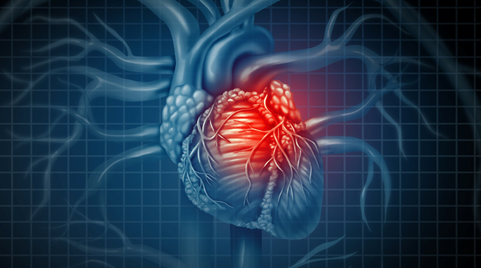

# Libraries & Dataset

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.multioutput import MultiOutputClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC, SVC
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier, XGBRFClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier, HistGradientBoostingClassifier

from imblearn.under_sampling import RandomUnderSampler
from category_encoders import LeaveOneOutEncoder
from category_encoders.target_encoder import TargetEncoder
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, auc

import warnings
warnings.filterwarnings("ignore")

In [ ]:
df = pd.read_csv("/kaggle/input/heart-attack-prediction/heart_attack_prediction_dataset.csv")
df.head()

In [ ]:
df.info()

In [ ]:
print(f"Total number of duplicate rows: {df.duplicated().sum()}")
print("---------------")
print(f"Total Missing Values          : {df.isnull().sum().sum()}")

**_"Blood Pressure" variable needs to be edited._**

In [ ]:
df["Blood_Sistolik_Pres"] = df["Blood Pressure"].apply(lambda x: x.split("/")[0]).astype(int)
df["Blood_Diyastolik _Pres"] = df["Blood Pressure"].apply(lambda x: x.split("/")[1]).astype(int)
df.drop("Blood Pressure", axis=1, inplace=True)

# Variable Distributions

> ### Target Variable Distribution

In [ ]:
plt.figure(figsize=(12,5))
sns.set(rc={'axes.facecolor':'c0c0c0', 'figure.facecolor':'lightblue'})
plt.subplot(1, 2, 1)
sns.barplot(x=df["Heart Attack Risk"].value_counts().index, y=df["Heart Attack Risk"].value_counts())
plt.subplot(1, 2, 2)
plt.pie(x=df["Heart Attack Risk"].value_counts(), autopct="%.1f%%", pctdistance=0.8,
        labels= df["Heart Attack Risk"].value_counts().index, shadow=True, explode=[0.05,0.05])
plt.suptitle("Heart Attack Risk Rates", fontsize=16)
plt.show()

> ### Distributions of Categorical Variables

In [ ]:
cat_fea_list = ['Sex', 'Diabetes', 'Family History', 'Smoking', 'Obesity', 'Alcohol Consumption', 'Diet',
        'Previous Heart Problems', 'Medication Use', 'Stress Level', 'Physical Activity Days Per Week',
        'Sleep Hours Per Day', 'Continent', 'Hemisphere', 'Country']

In [ ]:
plt.figure(figsize=(12,65))
sns.set(rc={'axes.facecolor':'c0c0c0', 'figure.facecolor':'lightblue'}, font_scale=0.8)

i = 0
j = 0
for col in cat_fea_list:
    feature = df.groupby(col)[col].count()
    plt.subplot(15, 2, i+1)
    sns.barplot(x=feature.index, y=feature.values)
    plt.title(col, fontsize=15)
    plt.xlabel("")
    #plt.xlabel(col, fontsize=12, color="#8b1a1a")
    if col == "Country":
        plt.xticks(rotation=90)
    if col == "Continent":
        plt.xticks(rotation=10)
        
    plt.subplot(15, 2, j+2)
    plt.pie(x=feature.values, autopct="%.1f%%", pctdistance=0.8, labels=feature.index)
    plt.title(col, fontsize=15)
    #plt.xlabel(col, fontsize=12, color="#8b1a1a")
    i += 2
    j += 2
plt.show()

> ### Distributions of Numerical Variables

In [ ]:
num_fea_list = ['Age', 'Cholesterol', 'Heart Rate', 'Exercise Hours Per Week', 'Sedentary Hours Per Day',
                'Income', 'BMI', 'Triglycerides', 'Blood_Sistolik_Pres', 'Blood_Diyastolik _Pres']

In [ ]:
plt.figure(figsize=(12,20))
sns.set(rc={'figure.facecolor':'lightblue'}, font_scale=0.7)

for i, col in enumerate(num_fea_list):
    plt.subplot(5, 2, i+1)
    sns.boxplot(df[col])
    plt.title(col, fontsize=14, color="#8b2252")
    plt.xlabel("\n")
plt.show()

# Encoding

In [ ]:
data = df.copy()

In [ ]:
# 1 for Male, 0 for Female
# 1 for Southern Hemisphere, 0 for Northern Hemisphere

le = LabelEncoder()
data[["Sex", "Hemisphere"]] = data[["Sex", "Hemisphere"]].agg(le.fit_transform)

In [ ]:
target_encoder = TargetEncoder()
data["Continent"] = target_encoder.fit_transform(data["Continent"], df["Heart Attack Risk"])
data["Country"] = target_encoder.fit_transform(data["Country"], df["Heart Attack Risk"])

In [ ]:
data = pd.get_dummies(data=data, columns=["Diet"])

In [ ]:
data = data[['Heart Attack Risk', 'Age', 'Cholesterol', 'Heart Rate', 'Exercise Hours Per Week',
        'Blood_Sistolik_Pres', 'Blood_Diyastolik _Pres', 'Sedentary Hours Per Day', 'Income', 'BMI',
        'Triglycerides', 'Stress Level', 'Physical Activity Days Per Week', 'Sleep Hours Per Day',
        'Diabetes', 'Family History', 'Smoking', 'Obesity', 'Alcohol Consumption','Previous Heart Problems',
        'Medication Use', 'Sex', 'Country', 'Continent', 'Hemisphere', 'Diet_Average', 'Diet_Healthy',
        'Diet_Unhealthy']]
data.head()

# Correlation

> ### Relationship of variables with heart attack risk

In [ ]:
heart_attack_corr = data.corr()["Heart Attack Risk"]
heart_attack_corr = heart_attack_corr.drop("Heart Attack Risk", axis=0).sort_values(ascending=False)

In [ ]:
plt.figure(figsize=(10,5))
sns.set(font_scale=0.8)
sns.barplot(x=heart_attack_corr.index, y=heart_attack_corr, color="#4a804d")
plt.xticks(rotation=90)
plt.ylim(-0.02, 0.05)
plt.title("Relationship of variables with heart attack risk", fontsize=15)
plt.show()

In [ ]:
plt.figure(figsize=(14,10))
sns.heatmap(data.corr(), annot=True, linewidths=0.4, fmt='.3f', cmap="Oranges", annot_kws={'size': 8, 'rotation': 45})
plt.title("Correlation Between Features", fontsize=16)
plt.show()

# Split (train/test)

In [ ]:
y = data["Heart Attack Risk"]
X = data.drop("Heart Attack Risk", axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, stratify=y, random_state=42)

# Standardization

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Model Building

In [ ]:
model_list = [LinearSVC(), LogisticRegression(), GradientBoostingClassifier(), MLPClassifier(),
              AdaBoostClassifier(), HistGradientBoostingClassifier(), SVC(), XGBRFClassifier(),
              CatBoostClassifier(verbose=False)]

roc_auc_list = []
accuracy_list = []

for model in model_list: 
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    roc_auc = roc_auc_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    
    roc_auc_list.append(roc_auc)
    accuracy_list.append(accuracy)
    
    print(f'Model Name: {model}')
    print(f'AUC ROC score is: {roc_auc:.3f}')
    print(f"accuracy score is: {accuracy:.3f}")
    print("\n", "-" * 50)

# Roc_Auc/Accuracy Scores of Models

In [ ]:
models = ["LinearSVC", "LogisticRegression", "GradientBoostingClassifier", "MLPClassifier",
        "AdaBoostClassifier", "HistGradientBoostingClassifier", "SVC", "XGBRFClassifier",
          "CatBoostClassifier"]

plt.figure(figsize=(8,4))
sns.barplot(x=roc_auc_list, y=models, color="#008b8b")
plt.xticks(rotation=45)
plt.axvline(x=0.508, lw=0.7, color="r", ls="--")
plt.title("Comparison of Models' Roc Auc Scores", fontsize=16)
plt.show()

In [ ]:
models = ["LinearSVC", "LogisticRegression", "GradientBoostingClassifier", "MLPClassifier",
    "AdaBoostClassifier", "HistGradientBoostingClassifier", "SVC", "XGBRFClassifier", "CatBoostClassifier"]

plt.figure(figsize=(8,4))
sns.barplot(x=accuracy_list, y=models, color="#008b8b")
plt.xticks(rotation=45)
plt.axvline(x=0.64168886, lw=0.7, color="r", ls="--")
plt.title("Comparison of Accuracy Scores of Models", fontsize=16)
plt.show()

<div class="alert alert-block alert-success"><b> </b>"If this work has provided a different perspective, I would be happy. Feel free to provide constructive criticism to help me improve." </div>